In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
# params
d = 5
T = 2

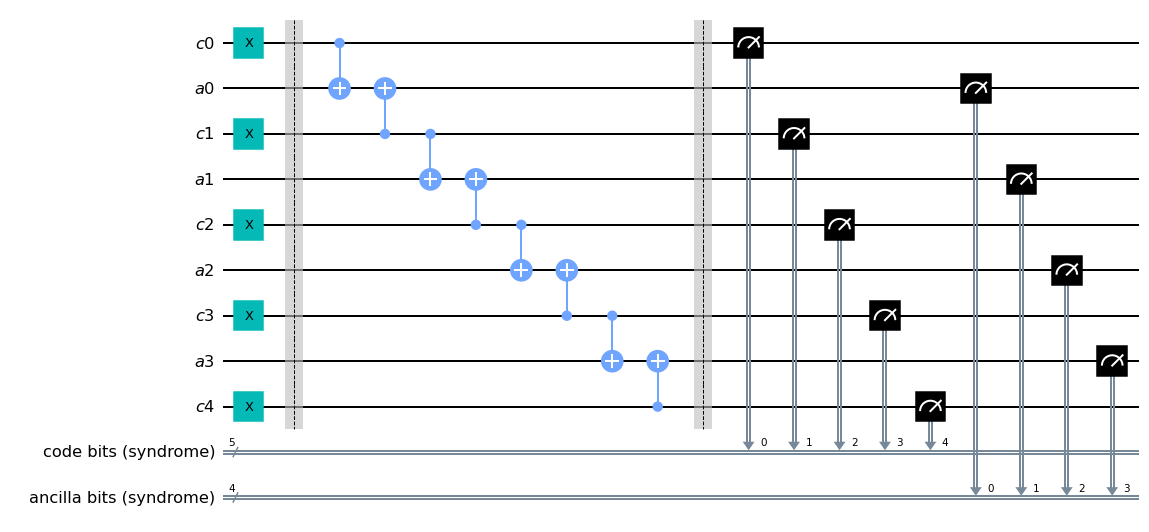

In [3]:
def draw_qc(code_qubit):
    ## Ancilla Qubit
    link_qubit = code_qubit - 1

    code_qregisters = []  # List of quantum code registers
    link_qregisters = []  # List of quantum link registers
    code_cregisters = ClassicalRegister(code_qubit, 'code bits (syndrome)')  # List of classical quantum registers
    link_cregisters = ClassicalRegister(link_qubit, 'ancilla bits (syndrome)')  # List of classical link registers

    ### appending code register list with code qubits and custom names
    for x in range(code_qubit):
        code_qregisters.append(QuantumRegister(1, 'c' + str(x)))
    ### appending link register list with code qubits and custom names
    for y in range(link_qubit):
        link_qregisters.append(QuantumRegister(1, 'a' + str(y)))

    ### appending parameter list with QuantumCircuit parameters
    param = []
    for x in range(code_qubit):
        param.append(code_qregisters[x])
        if x != code_qubit - 1:
            param.append(link_qregisters[x])
    bparam = param.copy()
    param.append(code_cregisters)
    param.append(link_cregisters)
    qc = QuantumCircuit(*param)

    ### Adding X Gate to code qubits
    for x in range(code_qubit):
        qc.x(code_qregisters[x])
    qc.barrier(*bparam)
    for x in range(link_qubit):
        for y in range(x, x + 2):
            qc.cx(code_qregisters[y], link_qregisters[x])
    qc.barrier(*bparam)
    # qc.measure(c0, cb[0])
    for x in range(code_qubit):
        qc.measure(code_qregisters[x], code_cregisters[x])
    for x in range(link_qubit):
        qc.measure(link_qregisters[x], link_cregisters[x])
    return qc

dq_circuit = draw_qc(d)
dq_circuit.draw("mpl")
# cq = QuantumRegister(2,'code_qubit')
# lq = QuantumRegister(1,'ancilla_qubit')
# qc = QuantumCircuit(cq,lq)
# qc.cx(cq[0],lq[0])
# qc.cx(cq[1],lq[0])
# print(qc)

In [4]:
from circuits import RepetitionCode
from fitters import GraphDecoder, lookuptable_decoding, postselection_decoding

In [5]:
empty_code = RepetitionCode(d,T)

In [13]:
def print_circuits(code):
    for log in ['0','1']:
        print('\n========= logical',log,'=========\n')
        print( code.circuit[log] )

print_circuits(empty_code)


========= logical 0 =========


========= logical 1 =========



In [7]:
empty_code.syndrome_measurement()
print_circuits(empty_code)


========= logical 0 =========

                    ┌───┐               ┌───┐               ┌─┐         ┌───┐»
      link_qubit_0: ┤ X ├───────────────┤ X ├───────────────┤M├─────────┤ X ├»
                    └─┬─┘┌───┐          └─┬─┘┌───┐          └╥┘┌─┐      └─┬─┘»
      link_qubit_1: ──┼──┤ X ├────────────┼──┤ X ├───────────╫─┤M├────────┼──»
                      │  └─┬─┘┌───┐       │  └─┬─┘┌───┐      ║ └╥┘┌─┐     │  »
      link_qubit_2: ──┼────┼──┤ X ├───────┼────┼──┤ X ├──────╫──╫─┤M├─────┼──»
                      │    │  └─┬─┘┌───┐  │    │  └─┬─┘┌───┐ ║  ║ └╥┘┌─┐  │  »
      link_qubit_3: ──┼────┼────┼──┤ X ├──┼────┼────┼──┤ X ├─╫──╫──╫─┤M├──┼──»
                      │    │    │  └─┬─┘  │    │    │  └─┬─┘ ║  ║  ║ └╥┘  │  »
      code_qubit_0: ──■────┼────┼────┼────┼────┼────┼────┼───╫──╫──╫──╫───■──»
                           │    │    │    │    │    │    │   ║  ║  ║  ║      »
      code_qubit_1: ───────■────┼────┼────■────┼────┼────┼───╫──╫──╫──╫──────»
                    

«                                                             0  1  2  3 


In [8]:
empty_code.x()
print_circuits(empty_code)


========= logical 0 =========

                    ┌───┐               ┌───┐               ┌─┐         ┌───┐»
      link_qubit_0: ┤ X ├───────────────┤ X ├───────────────┤M├─────────┤ X ├»
                    └─┬─┘┌───┐          └─┬─┘┌───┐          └╥┘┌─┐      └─┬─┘»
      link_qubit_1: ──┼──┤ X ├────────────┼──┤ X ├───────────╫─┤M├────────┼──»
                      │  └─┬─┘┌───┐       │  └─┬─┘┌───┐      ║ └╥┘┌─┐     │  »
      link_qubit_2: ──┼────┼──┤ X ├───────┼────┼──┤ X ├──────╫──╫─┤M├─────┼──»
                      │    │  └─┬─┘┌───┐  │    │  └─┬─┘┌───┐ ║  ║ └╥┘┌─┐  │  »
      link_qubit_3: ──┼────┼────┼──┤ X ├──┼────┼────┼──┤ X ├─╫──╫──╫─┤M├──┼──»
                      │    │    │  └─┬─┘  │    │    │  └─┬─┘ ║  ║  ║ └╥┘  │  »
      code_qubit_0: ──■────┼────┼────┼────┼────┼────┼────┼───╫──╫──╫──╫───■──»
                           │    │    │    │    │    │    │   ║  ║  ║  ║      »
      code_qubit_1: ───────■────┼────┼────■────┼────┼────┼───╫──╫──╫──╫──────»
                    

In [9]:
empty_code.readout()
print_circuits(empty_code)

CircuitError: 'register name "code_bit" already exists'

In [ ]:
circuits = code.get_circuit_list()
job = execute( circuits, Aer.get_backend('qasm_simulator') )
raw_results = {}
for log in ['0','1']:
    raw_results[log] = job.result().get_counts(log)
    print('\n========= logical',log,'=========\n')
    print(raw_results[log])

In [ ]:
code.process_results( raw_results )

In [ ]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])

    return noise_model

In [ ]:
noise_model = get_noise(0.04,0.04)

In [ ]:
def get_syndrome(code,noise_model,shots=1014):

    circuits = code.get_circuit_list()

    job = execute( circuits, Aer.get_backend('qasm_simulator'),noise_model=noise_model, shots=shots )
    raw_results = {}
    for log in ['0','1']:
        raw_results[log] = job.result().get_counts(log)

    return code.process_results( raw_results )

In [ ]:
get_syndrome(code,noise_model)

In [ ]:
dec = GraphDecoder( RepetitionCode(4,2) )

In [ ]:
dec.matching('1 0  001 100 100')

In [ ]:
for d in range(3,8):

    code = RepetitionCode(d,2)

    results = get_syndrome(code,noise_model=noise_model,shots=8192)

    dec = GraphDecoder(code)

    logical_prob_match = dec.get_logical_prob(results)
    logical_prob_lookup = lookuptable_decoding(results,results)
    logical_prob_post = postselection_decoding(results)

    for log in ['0','1']:
        print('d =',d,',log =',log)
        print('logical error probability for matching      =',logical_prob_match[log])
        print('logical error probability for lookup table  =',logical_prob_lookup[log])
        print('logical error probability for postselection =',logical_prob_post[log])
        print('')
    print('')